In [1]:
import os
import sys
import gc
# assuming data, models, engine in flicc directory:
flicc_path = os.path.realpath("__file__").split('grid_search')[0]
sys.path.append(flicc_path)
import torch
from data import ClimateDataset
from models import ClassificationModel
from engine import Engine

In [2]:
model_checkpoint='gpt2'

In [3]:
results = {'test_acc':[],
           'test_f1':[],
           'eval_acc':[],
           'eval_f1':[],
           'rank, alpha':[]}

In [4]:
lr = 1.0e-4
wd = 0.1
alphas = [8, 16]
ranks = [8, 16]
lora_dropout = 0.0


for a,r in zip(alphas, ranks):
    print(f'Grid search {model_checkpoint}, learning rate {lr} wd: {wd}, Lora alpha {a}, rank {r}')
    data = ClimateDataset(model_to_train=2,model_checkpoint=model_checkpoint,dataset_url=flicc_path,batch_size=32)
    data.setup_dataloaders()
    model = ClassificationModel(model_checkpoint=data.model_checkpoint,
                            num_labels=data.num_labels,
                            lora=True,
                            r=r,
                            alpha=a,
                            dropout=lora_dropout)
    trainer = Engine(epochs=30,labels=data.labels)
    trainer.model = model.model
    trainer.dataset_encoded = data.dataset_encoded
    test_acc, test_f1, eval_acc, eval_f1 = trainer.run(lr=lr,
                          wd=wd,
                          train_dataloader=data.train_dataloader,
                          eval_dataloader=data.eval_dataloader,
                          test_dataloader=data.test_dataloader,
                          early_stop=3)
    results['test_acc'].append(test_acc)
    results['test_f1'].append(test_f1)
    results['eval_acc'].append(eval_acc)
    results['eval_f1'].append(eval_f1)
    results['rank, alpha'].append(r)
    print('### '*10)
    print(results)
    print('### '*10)
    with torch.no_grad():
        torch.cuda.empty_cache()
    del data, model, trainer, test_acc, test_f1, eval_acc, eval_f1
    gc.collect()

Grid search gpt2, learning rate 0.0001 wd: 0.1, Lora alpha 8, rank 8


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/mnt/software/miniconda3/lib/python3.11/site-packages/peft/tuners/lora/model.py:311: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


1 / 30: Train Loss:	2.1326	Val Loss:	1.6078	Accuracy:	0.3782	F1:	0.3622
2 / 30: Train Loss:	1.5912	Val Loss:	1.7064	Accuracy:	0.4202	F1:	0.3773
3 / 30: Train Loss:	1.5913	Val Loss:	1.6387	Accuracy:	0.3950	F1:	0.3564
4 / 30: Train Loss:	1.4801	Val Loss:	1.5550	Accuracy:	0.3950	F1:	0.3568
5 / 30: Train Loss:	1.4135	Val Loss:	1.5024	Accuracy:	0.3866	F1:	0.3498
No improvement for 3 epochs. Stopping early.
best (higgest macro f1-score) val results:
                    precision    recall  f1-score   support

 misrepresentation       0.38      0.63      0.47        38
oversimplification       0.44      0.11      0.18        36
slothful induction       0.48      0.49      0.48        45

          accuracy                           0.42       119
         macro avg       0.43      0.41      0.38       119
      weighted avg       0.44      0.42      0.39       119

test results:
                    precision    recall  f1-score   support

 misrepresentation       0.40      0.45      0.43     

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/mnt/software/miniconda3/lib/python3.11/site-packages/peft/tuners/lora/model.py:311: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


1 / 30: Train Loss:	2.0799	Val Loss:	1.6706	Accuracy:	0.4034	F1:	0.3837
2 / 30: Train Loss:	1.5775	Val Loss:	1.7383	Accuracy:	0.4286	F1:	0.3926
3 / 30: Train Loss:	1.5752	Val Loss:	1.5994	Accuracy:	0.3950	F1:	0.3567
4 / 30: Train Loss:	1.4555	Val Loss:	1.5361	Accuracy:	0.3613	F1:	0.3262
5 / 30: Train Loss:	1.3861	Val Loss:	1.4804	Accuracy:	0.3697	F1:	0.3365
No improvement for 3 epochs. Stopping early.
best (higgest macro f1-score) val results:
                    precision    recall  f1-score   support

 misrepresentation       0.37      0.63      0.47        38
oversimplification       0.50      0.14      0.22        36
slothful induction       0.50      0.49      0.49        45

          accuracy                           0.43       119
         macro avg       0.46      0.42      0.39       119
      weighted avg       0.46      0.43      0.40       119

test results:
                    precision    recall  f1-score   support

 misrepresentation       0.42      0.50      0.46     

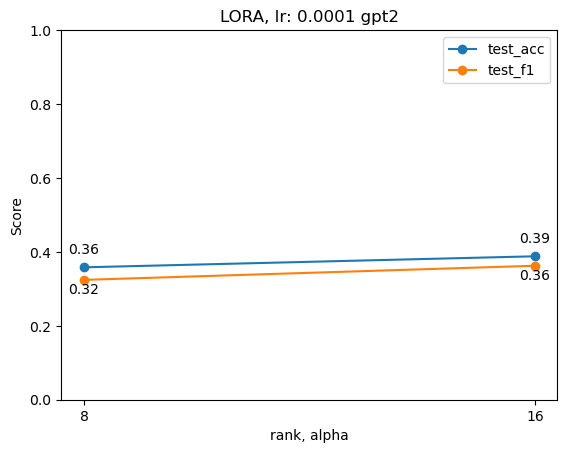

In [5]:
Engine.plot_grid_search(df=results,
                        title=f'LORA, lr: {lr} {model_checkpoint}',
                        column='rank, alpha',
                        sci_format=False)

In [6]:
%reset -f